In [1]:
# Imports

import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

In [2]:
# Load Names 

with open("Census Income Data Set/adult.names", "r") as f:
    content = f.read()
    print(content)

| This data was extracted from the census bureau database found at
| http://www.census.gov/ftp/pub/DES/www/welcome.html
| Donor: Ronny Kohavi and Barry Becker,
|        Data Mining and Visualization
|        Silicon Graphics.
|        e-mail: ronnyk@sgi.com for questions.
| Split into train-test using MLC++ GenCVFiles (2/3, 1/3 random).
| 48842 instances, mix of continuous and discrete    (train=32561, test=16281)
| 45222 if instances with unknown values are removed (train=30162, test=15060)
| Duplicate or conflicting instances : 6
| Class probabilities for adult.all file
| Probability for the label '>50K'  : 23.93% / 24.78% (without unknowns)
| Probability for the label '<=50K' : 76.07% / 75.22% (without unknowns)
|
| Extraction was done by Barry Becker from the 1994 Census database.  A set of
|   reasonably clean records was extracted using the following conditions:
|   ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
|
| Prediction task is to determine whether a person makes over

In [3]:
# Load data

columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", 
           "capital-loss", "hours-per-week", "native-country", "income"]

train_data = pd.read_csv("Census Income Data Set/adult.data", header=None, names=columns, sep=",", skipinitialspace=True)

test_data = pd.read_csv("Census Income Data Set/adult.test", header=None, names=columns, sep=",", skipinitialspace=True, skiprows=1)

In [4]:
# Data Preprocessing

test_data["income"] = test_data["income"].str.replace(".", "", regex=False).str.strip()

train_data = train_data.replace("?", pd.NA).dropna()
test_data = test_data.replace("?", pd.NA).dropna()

x_train = train_data.drop("income", axis=1)
y_train = train_data["income"]
x_test = test_data.drop("income", axis=1)
y_test = test_data["income"]

x_train = pd.get_dummies(x_train)
x_test = pd.get_dummies(x_test)

x_train, x_test = x_train.align(x_test, join="left", axis=1, fill_value=0)

print("Training set:", x_train.shape, y_train.shape)
print("Test set:", x_test.shape, y_test.shape)

Training set: (30162, 104) (30162,)
Test set: (15060, 104) (15060,)


In [5]:
# Validation
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train,
                                            test_size=0.20, 
                                            random_state=0, 
                                            stratify=y_train)

print("Train-subset:", x_tr.shape, y_tr.shape)
print("Valid-subset:", x_val.shape, y_val.shape)

Train-subset: (24129, 104) (24129,)
Valid-subset: (6033, 104) (6033,)


In [6]:
# Tuning on Validation Set (Decision Tree)
tree_clf = DecisionTreeClassifier(random_state=0, 
                                  #max_depth=None, 
                                  #max_depth=5, 
                                  max_depth=10, 
                                  #max_depth=15
                                 )

tree_clf.fit(x_tr, y_tr)
y_pred_tree = tree_clf.predict(x_val)

print("Accuracy:", accuracy_score(y_val, y_pred_tree))
print(classification_report(y_val, y_pred_tree))

Accuracy: 0.8521465274324548
              precision    recall  f1-score   support

       <=50K       0.87      0.94      0.91      4531
        >50K       0.77      0.58      0.66      1502

    accuracy                           0.85      6033
   macro avg       0.82      0.76      0.78      6033
weighted avg       0.85      0.85      0.84      6033



In [7]:
# Decision Tree (Model 1)

tree_clf = DecisionTreeClassifier(random_state=0, max_depth=10)

start = time.time()
tree_clf.fit(x_train, y_train)
end = time.time()
print("Decision Tree Training time:", round(end - start, 4), "s")

start = time.time()
y_pred_tree = tree_clf.predict(x_test)
end = time.time()
print("Decision Tree Prediction time:", round(end - start, 4), "s")

print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print("Decision Tree Classification report:")
print(classification_report(y_test, y_pred_tree))

Decision Tree Training time: 0.4536 s
Decision Tree Prediction time: 0.0148 s
Accuracy: 0.8560424966799469
Decision Tree Classification report:
              precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91     11360
        >50K       0.76      0.60      0.67      3700

    accuracy                           0.86     15060
   macro avg       0.82      0.77      0.79     15060
weighted avg       0.85      0.86      0.85     15060



In [8]:
# Tuning on Validation Set (Logistic Regression)

scaler = StandardScaler()

x_tr_scaled = scaler.fit_transform(x_tr)
x_val_scaled = scaler.transform(x_val)

log_clf = LogisticRegression(max_iter=1000, random_state=0, 
                             #C=0.1,
                             #C=1.0,
                             C=10.0
                            )

log_clf.fit(x_tr_scaled, y_tr)
y_pred_log = log_clf.predict(x_val_scaled)
print("Accuracy:", accuracy_score(y_val, y_pred_log))
print(classification_report(y_val, y_pred_log))

Accuracy: 0.846676611967512
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      4531
        >50K       0.74      0.60      0.66      1502

    accuracy                           0.85      6033
   macro avg       0.81      0.76      0.78      6033
weighted avg       0.84      0.85      0.84      6033



In [9]:
# Logistic Regression (Model 2)

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

log_clf = LogisticRegression(max_iter=1000, random_state=0, C=10.0)

start = time.time()
log_clf.fit(x_train_scaled, y_train)
end = time.time()
print("Logistic Regression Training time:", round(end - start, 4), "s")

start = time.time()
y_pred_log = log_clf.predict(x_test_scaled)
end = time.time()
print("Logistic Regression Prediction time:", round(end - start, 4), "s")

print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression Classification report:")
print(classification_report(y_test, y_pred_log))

Logistic Regression Training time: 0.5129 s
Logistic Regression Prediction time: 0.005 s
Accuracy: 0.847675962815405
Logistic Regression Classification report:
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90     11360
        >50K       0.73      0.60      0.66      3700

    accuracy                           0.85     15060
   macro avg       0.80      0.77      0.78     15060
weighted avg       0.84      0.85      0.84     15060



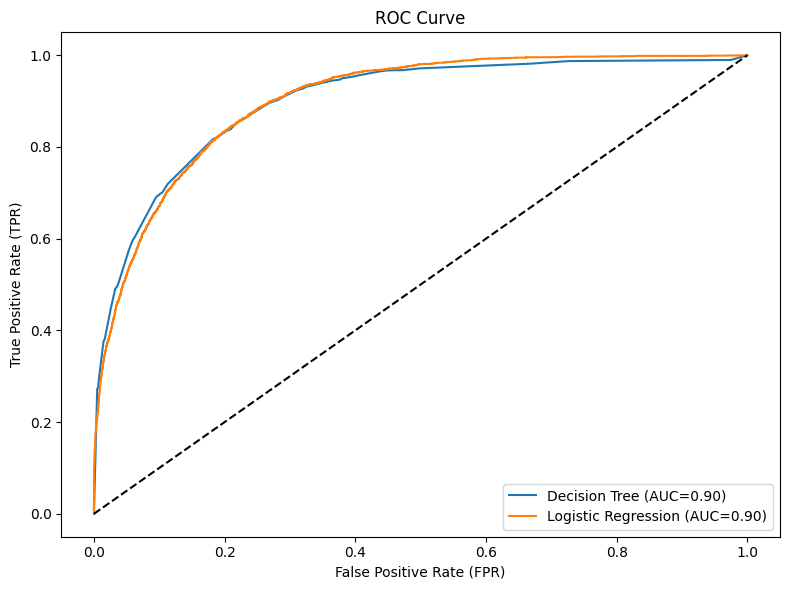

In [10]:
# ROC Curve

y_test_bin = y_test.map({">50K": 1, "<=50K": 0}).values

y_prob_tree = tree_clf.predict_proba(x_test)[:, 1]         
y_prob_log  = log_clf.predict_proba(x_test_scaled)[:, 1]

fpr_tree, tpr_tree, _ = roc_curve(y_test_bin, y_prob_tree)
fpr_log, tpr_log,  _ = roc_curve(y_test_bin, y_prob_log)
auc_tree = auc(fpr_tree, tpr_tree)
auc_log  = auc(fpr_log,  tpr_log)

plt.figure(figsize=(8,6))
plt.plot(fpr_tree, tpr_tree, label=f"Decision Tree (AUC={auc_tree:.2f})")
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC={auc_log:.2f})")
plt.plot([0,1],[0,1], "k--")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

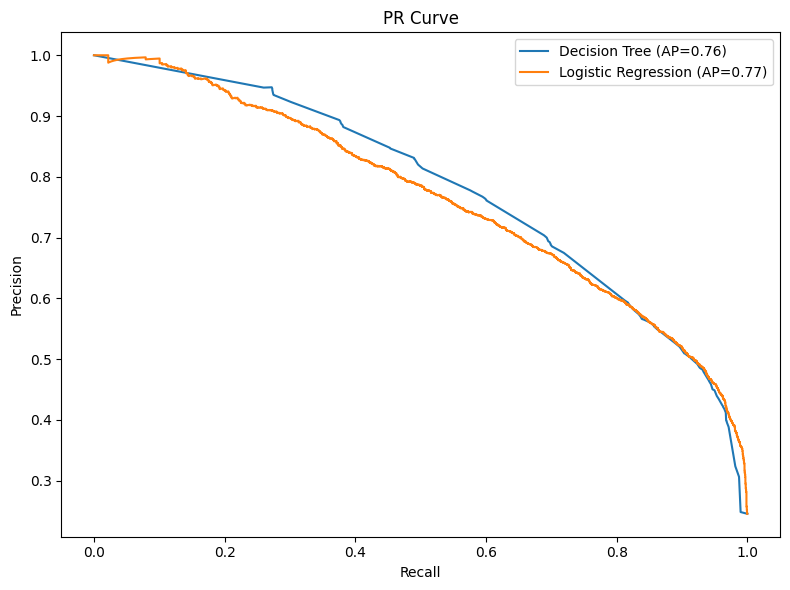

In [11]:
# PR Curve 

prec_tree, rec_tree, _ = precision_recall_curve(y_test_bin, y_prob_tree)
prec_log, rec_log, _ = precision_recall_curve(y_test_bin, y_prob_log)
ap_tree = average_precision_score(y_test_bin, y_prob_tree)
ap_log  = average_precision_score(y_test_bin, y_prob_log)

plt.figure(figsize=(8, 6))
plt.plot(rec_tree, prec_tree, label=f"Decision Tree (AP={ap_tree:.2f})")
plt.plot(rec_log, prec_log, label=f"Logistic Regression (AP={ap_log:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve")
plt.legend()
plt.tight_layout()
plt.show()